# Geometry Analysis

In [29]:
import os
import numpy as np
import itertools
import csv
from pymatgen.core import Structure
from pymatgen.analysis.local_env import VoronoiNN

# Define structure paths
all_structures_path = {
"/path-to-the-directory-containing-folders-initial-and-final"
}

def find_nearest_neighbors(structure):
    """Finds the 6 nearest neighbors to the 0th atom in a structure."""
    vnn = VoronoiNN()
    neighbors = vnn.get_nn_info(structure, 0)
    neighbor_list = [(neighbor['site_index'], neighbor['site'].coords, neighbor['poly_info']['solid_angle'])
                     for neighbor in neighbors]
    return sorted(neighbor_list, key=lambda x: structure[0].distance(structure[x[0]]))[:6]

def compute_relevant_distances(structure_file):
    """Computes distances for the 6 nearest neighbors of the 0th atom."""
    structure = Structure.from_file(structure_file)
    nearest_neighbors = find_nearest_neighbors(structure)
    print(nearest_neighbors)
    indices = [index for index, _, _ in nearest_neighbors]
    atom_distances = {(0, index): structure[0].distance(structure[index]) for index in indices}
    pairwise_distances = {(i, j): structure[i].distance(structure[j]) for i, j in itertools.combinations(indices, 2)}
    return {**atom_distances, **pairwise_distances}

def compute_solid_angles(structure_file):
    """Computes the solid angles of Voronoi faces for the 6 nearest neighbors."""
    structure = Structure.from_file(structure_file)
    nearest_neighbors = find_nearest_neighbors(structure)
    return {index: solid_angle for index, _, solid_angle in nearest_neighbors}

def compute_all_differences(structure_file_1, structure_file_2):
    """Computes differences in distances and solid angles between two structures."""
    distances_1, distances_2 = compute_relevant_distances(structure_file_1), compute_relevant_distances(structure_file_2)
    solid_angles_1, solid_angles_2 = compute_solid_angles(structure_file_1), compute_solid_angles(structure_file_2)
    
    distance_differences = [abs(distances_1[p] - distances_2[p]) for p in distances_1 if p in distances_2]
    solid_angle_differences = [abs(solid_angles_1[i] - solid_angles_2[i]) for i in solid_angles_1 if i in solid_angles_2]
    
    return {
        "Mean Distance Difference (Å)": np.mean(distance_differences) if distance_differences else 0,
        "Max Distance Difference (Å)": max(distance_differences) if distance_differences else 0,
        "Mean Solid Angle Difference (sr)": np.mean(solid_angle_differences) if solid_angle_differences else 0,
        "Max Solid Angle Difference (sr)": max(solid_angle_differences) if solid_angle_differences else 0
    }

# CSV Output File
output_csv = "full_path/structure_analysis_MLIP_run_system_name.csv"
#Use the same code with MLIP replaced as LI in the output_csv for comparing LI against DFT-NEB
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Structure", "Index", "Mean Distance Difference (Å)", "Max Distance Difference (Å)",
                     "Mean Solid Angle Difference (sr)", "Max Solid Angle Difference (sr)"])
    
    for structure_name, base_path in all_structures_path.items():
        for j in range(1, 8):
            dft_structure_path = os.path.join(base_path, f"0{j}/CONTCAR")
            mace_structure_path = os.path.join(base_path, f"MLIP_folder_name/neb_optimized_{j}.vasp")  # for MLIPs
            #mace_structure_path = os.path.join(base_path, f"0{j}/POSCAR") # For LI
            if os.path.exists(dft_structure_path) and os.path.exists(mace_structure_path):
                results = compute_all_differences(dft_structure_path, mace_structure_path)
                writer.writerow([structure_name, j, results["Mean Distance Difference (Å)"], results["Max Distance Difference (Å)"],
                                 results["Mean Solid Angle Difference (sr)"], results["Max Solid Angle Difference (sr)"]])
                print(f"Processed {structure_name}, Index {j}")
            else:
                print(f"Skipping {structure_name}, Index {j} (Missing Files)")

print(f"\n✅ Results saved to {output_csv}")


[(18, array([3.54342312, 4.57708276, 7.29901734]), 1.7455086737824037), (11, array([ 4.83052443,  4.5476067 , 11.43086696]), 1.862810231933503), (15, array([6.76048625, 5.65145149, 9.83765249]), 1.7254586448946212), (22, array([5.72291095, 3.09387388, 6.83762441]), 1.5016150124240506), (20, array([3.79988199, 1.97470917, 8.38723142]), 1.5212987503415594), (13, array([ 7.0441553 ,  3.06992161, 10.70920379]), 1.21821602309218)]
[(18, array([3.59586288, 4.5837496 , 7.35959461]), 1.767897981748102), (11, array([ 4.79264877,  4.54653157, 11.38603976]), 1.864805217253159), (15, array([6.80563472, 5.64182807, 9.74102833]), 1.7549817005680817), (22, array([5.79822123, 3.03116646, 6.89746674]), 1.6182245205942674), (20, array([3.81024848, 1.97985306, 8.47267792]), 1.6528144119717507), (13, array([ 6.97928267,  2.99460333, 10.68908129]), 1.4397171369227588)]
Processed Fe2S3O12, Index 1
[(11, array([ 4.86930217,  4.48375946, 11.49893701]), 2.1506920575804966), (18, array([3.52223133, 4.6032206 , 

/home/achinthyakrishnab/miniconda3/envs/alchemical-mlip/lib/python3.10/site-packages/pymatgen/io/vasp/inputs.py:438: BadPoscarWarning: Ignoring selective dynamics tag, as no ionic degrees of freedom were fixed.
  warnings.warn(


Processed Fe2S3O12, Index 2
[(11, array([ 4.92275926,  4.39188401, 11.53988408]), 2.148584990464116), (15, array([6.69200172, 5.70630218, 9.8780728 ]), 1.8799473175217492), (18, array([3.5152161 , 4.59478701, 7.36508154]), 1.8617008971242295), (25, array([5.43136001, 7.12278202, 8.50397554]), 1.8333429908591157), (34, array([2.12451885, 5.44165306, 9.07182727]), 1.703098035324182), (10, array([2.3394041 , 5.51697893, 7.57627442]), 0.07683566753449046)]
[(11, array([ 4.84999961,  4.47465534, 11.53943304]), 2.260596816050105), (18, array([3.58400898, 4.61449629, 7.33135644]), 1.88289644374514), (15, array([6.85533679, 5.73315448, 9.7803399 ]), 1.8897873777032328), (25, array([5.44997985, 7.14370501, 8.53366152]), 1.6632019376086342), (34, array([2.28012032, 5.31100893, 9.16398671]), 1.6081908876639868), (10, array([2.42072952, 5.49053151, 7.66361535]), 0.04913485616854134)]
Processed Fe2S3O12, Index 3
[(11, array([ 4.94715414,  4.33180385, 11.51132806]), 2.0099618073447925), (25, array([

[(36, array([4.30553719, 4.29820071, 5.46463481]), 3.0286986644274427), (61, array([4.89783736, 3.00800679, 8.52267353]), 2.1695948436894676), (55, array([2.20656657, 3.01081402, 7.71846922]), 2.1357731017735744), (57, array([3.43227421, 5.40518096, 8.52081249]), 2.1125070024616255), (19, array([3.21814007, 3.63029307, 9.23592093]), 0.6463050270874694), (24, array([5.96358973, 3.6348702 , 4.91034049]), 0.0030722458180302116)]
[(36, array([4.2911276 , 4.29995639, 5.4564745 ]), 3.0224142698180376), (61, array([4.93264715, 2.99589614, 8.51186308]), 2.318833767478173), (57, array([3.45484099, 5.40407479, 8.50223539]), 2.018372480563532), (55, array([2.22848243, 3.00801117, 7.70024453]), 2.018742990917252), (19, array([3.23840722, 3.62697692, 9.22098266]), 0.6361827940420972), (24, array([5.96245911, 3.64116431, 4.89649303]), 0.030667729220129)]
Processed LiCoO2_2, Index 4
[(36, array([4.30899574, 4.31317544, 5.4592824 ]), 3.0125679464204684), (61, array([4.90409679, 2.98289547, 8.50800971]

Processed Mg0.148Ti2S4, Index 7
[(30, array([4.2276222 , 6.93616841, 4.21381764]), 2.869886255902477), (36, array([1.91663243, 6.93587775, 1.90295619]), 2.86989625872959), (33, array([4.24116523, 9.41195076, 1.88957055]), 2.6783614186336258), (23, array([1.97080775, 9.35194314, 4.15961255]), 1.9899876075052638), (51, array([6.23223455, 7.38649015, 2.19095774]), 0.6940345892174923), (45, array([ 3.93923308,  7.38242525, -0.10230175]), 0.6937139793414593)]
[(36, array([1.93090263, 6.91760286, 1.90740578]), 2.878248812551341), (30, array([4.22226324, 6.91662145, 4.19744122]), 2.878133917864632), (33, array([4.22306172, 9.41842141, 1.91259797]), 2.6385518760925675), (23, array([1.99514255, 9.35146123, 4.13780377]), 2.086330642183947), (51, array([6.19966031, 7.45953546, 2.16352176]), 0.6634432761349661), (45, array([ 3.96416137,  7.44945696, -0.06968237]), 0.6670788367971047)]
Processed MgMn2O4_I41amd, Index 1
[(36, array([1.9195207 , 6.9339768 , 1.89949121]), 2.7371781402530306), (30, arr

Processed MgSc2Se4, Index 4
[(53, array([5.66360673, 5.66360913, 2.69401321]), 2.470588117476175), (35, array([2.69401273, 5.66360827, 5.66360857]), 2.470586688540718), (44, array([5.66360822, 2.69401537, 5.66360864]), 2.470586434585909), (31, array([8.37906646, 5.52543853, 5.52543881]), 1.5951047809380194), (40, array([5.52544093, 8.37907059, 5.52543985]), 1.5951029819988898), (49, array([5.52543867, 5.52543923, 8.37906842]), 1.5951020567329768)]
[(53, array([5.66699799, 5.67094956, 2.70173564]), 2.489119186230704), (44, array([5.66943258, 2.70379138, 5.67066144]), 2.4876373735322024), (35, array([2.70376206, 5.66729515, 5.66682251]), 2.480050463284071), (31, array([8.38585542, 5.5302125 , 5.53159698]), 1.5775842004737923), (40, array([5.52704962, 8.38828017, 5.52862005]), 1.5699718514735075), (49, array([5.5293254 , 5.5304094 , 8.38608712]), 1.5690176734754884)]
Processed MgSc2Se4, Index 5
[(53, array([5.68888654, 5.68888775, 2.6406548 ]), 2.747265425347257), (44, array([5.68888659, 

[(70, array([9.14022291, 9.29786263, 8.19840727]), 2.204226612670197), (102, array([ 8.19420461, 12.90031162,  9.48596789]), 2.0737043017625223), (118, array([ 8.03639876,  8.12452243, 12.05469274]), 1.8952689906055922), (86, array([ 9.36608126, 11.82619696, 13.21117901]), 1.8064367267054604), (31, array([ 6.93133612, 10.38703388, 13.61220216]), 0.6067553589513408), (13, array([10.41972816, 13.80874705, 11.26663775]), 0.504515856085136)]
Processed Na3PS4, Index 7
[(76, array([5.58651452, 5.05183265, 0.16241839]), 2.126881262757019), (108, array([8.54767395, 5.04474607, 0.7230082 ]), 2.1076183688823096), (60, array([6.51090354, 5.03067501, 3.86521712]), 1.8913583228571829), (84, array([4.42178788, 3.6201935 , 2.32265478]), 1.3270399837767202), (80, array([9.01262516, 3.61204369, 3.02311175]), 1.166567511008886), (75, array([5.63115524, 2.17732178, 0.20606599]), 1.0640068327496515)]
[(108, array([8.55612354, 4.98055327, 0.76507949]), 2.045888858249078), (76, array([5.6422312 , 5.15028152

[(76, array([5.64775304, 4.55172237, 8.64529343]), 2.957420363170108), (56, array([4.13251214, 4.54101356, 5.85313728]), 2.842618855762553), (104, array([6.9183978 , 2.76828837, 5.7869488 ]), 2.1923584833239413), (40, array([4.19457271, 4.55994983, 9.16628035]), 0.07903988203414415), (28, array([7.52875882, 4.58346536, 4.81340308]), 0.6249433458992437), (82, array([6.99230305, 6.39668736, 5.7462071 ]), 1.2484789390704358)]
[(76, array([5.65640666, 4.56137278, 8.63565079]), 2.930845563032804), (56, array([4.10366139, 4.5388093 , 5.85264747]), 2.807662606529431), (104, array([6.94735897, 2.73021825, 5.78516973]), 2.1523883709189273), (28, array([7.53362162, 4.58125719, 4.8158893 ]), 0.6709214909930756), (40, array([4.20511962, 4.55740681, 9.15982204]), 0.07588158039042667), (82, array([7.01712717, 6.42105171, 5.75975159]), 1.2164557937023723)]
Processed O-LiFePO4, Index 3
[(76, array([5.64611498, 4.55282294, 8.65137241]), 2.987565620043273), (56, array([4.1271269 , 4.5523444 , 5.85044562

Processed g-Li3PO4_1, Index 5
[(111, array([6.26320989, 4.69115215, 1.9629664 ]), 2.973872930849936), (67, array([3.56741177, 2.71728192, 0.97378695]), 2.4872310872626264), (104, array([ 4.79318734,  4.55978484, -1.03758352]), 2.306530958489816), (17, array([ 3.52185337,  3.04573939, -1.02872685]), 0.4377907139748486), (95, array([5.75743459, 1.4841746 , 0.98651902]), 1.1503168395227013), (51, array([4.3138981 , 1.45944878, 1.5232855 ]), 0.1396830235564585)]
[(111, array([6.23926226, 4.7205674 , 1.96801968]), 2.992079545101098), (67, array([3.55493021, 2.72350698, 0.96777562]), 2.4519600898725664), (104, array([ 4.76492966,  4.5949288 , -1.04042644]), 2.2623638372461867), (17, array([ 3.5249841 ,  3.06585071, -1.02610118]), 0.44991735734363963), (95, array([5.74317606, 1.48744359, 0.99168748]), 1.1580442003346085), (51, array([4.30104998, 1.46718519, 1.5234355 ]), 0.14094486721582913)]
Processed g-Li3PO4_1, Index 6
[(111, array([6.25192758, 4.68250635, 1.9566354 ]), 2.869268166645971),

[(110, array([6.28938416, 4.68364552, 1.96275036]), 3.118678054836069), (66, array([3.71437084, 2.74343478, 0.94697988]), 2.2781588387333986), (103, array([ 4.76805667,  4.59969067, -1.07116202]), 1.8886244116361985), (94, array([5.81039375, 1.4646093 , 1.00322599]), 1.8005525425708644), (83, array([ 6.93276075,  3.34724721, -1.10217428]), 1.5232975899558494), (50, array([4.3421686 , 1.45694623, 1.51951291]), 0.14709249692419435)]
[(110, array([6.28540744, 4.70848075, 1.99033862]), 3.1672201669269735), (66, array([3.70515118, 2.72237213, 0.92205512]), 2.1548147016300754), (103, array([ 4.75808449,  4.60565159, -1.08800491]), 1.7686080032975906), (94, array([5.79992135, 1.45107727, 0.99181416]), 1.8187740550579001), (83, array([ 6.93291061,  3.34971231, -1.08840195]), 1.5891880234097688), (50, array([4.3395902 , 1.45372263, 1.52678042]), 0.1562311738761844)]
Processed g-Li3PO4_9, Index 2
[(110, array([6.28685519, 4.69409958, 1.96358874]), 2.921051204012835), (66, array([3.72310192, 2.73

# Evaluate \theta

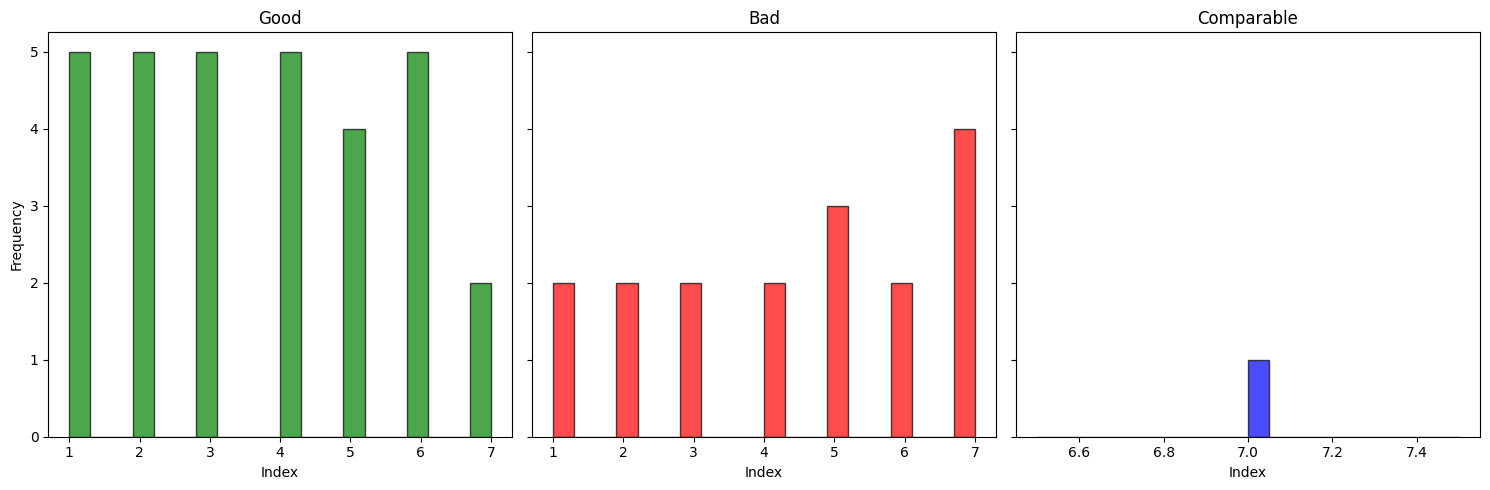

Total Counts:
Label
Good          31
Bad           17
Comparable     1
Name: count, dtype: int64


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load CSV files
file2 = "full-path-to-directory-containing-MLIP-csv-file/structure_analysis_MLIP_run_system_name.csv" #MLIP file 
file1 = "full-path-to-directory-containing-LI-csv-file/structure_analysis_LI_run_system_name.csv" #LI file
#plot_output_dir = "/Users/achinthyakrishna07/Downloads/migration_barrier/plots/structure_analysis_tight_run_eb_v_interpola.png"  # Replace with actual output directory
output_file = 'full-path'
# Ensure the output directory exists
#os.makedirs(plot_output_dir, exist_ok=True)

df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Merge the two datasets on Structure and Index
merged_df = df1.merge(df2, on=["Structure", "Index"], suffixes=("_sys1", "_sys2"))

# Compute differences (df2 - df1)
merged_df["Diff_Mean_Dist"] = merged_df["Mean Distance Difference (Å)_sys2"] - merged_df["Mean Distance Difference (Å)_sys1"]
merged_df["Diff_Max_Dist"] = merged_df["Max Distance Difference (Å)_sys2"] - merged_df["Max Distance Difference (Å)_sys1"]
merged_df["Diff_Mean_Solid_Angle"] = merged_df["Mean Solid Angle Difference (sr)_sys2"] - merged_df["Mean Solid Angle Difference (sr)_sys1"]
merged_df["Diff_Max_Solid_Angle"] = merged_df["Max Solid Angle Difference (sr)_sys2"] - merged_df["Max Solid Angle Difference (sr)_sys1"]

# Find the maximum of these differences
merged_df["Max_Diff"] = merged_df[["Diff_Mean_Dist", "Diff_Max_Dist", "Diff_Mean_Solid_Angle", "Diff_Max_Solid_Angle"]].max(axis=1)

# Assign labels
conditions = [
    (merged_df["Max_Diff"] > 0.1),
    (merged_df["Max_Diff"] < 0.01)
]
labels = ["Bad", "Good"]
merged_df["Label"] = np.select(conditions, labels, default="Comparable")

# Save the max difference details to file
max_diff_df = merged_df[["Structure", "Index", "Max_Diff", "Label"]]
max_diff_df.to_csv(output_file, index=False)

# Separate data based on labels
good_data = merged_df[merged_df["Label"] == "Good"]["Index"]
bad_data = merged_df[merged_df["Label"] == "Bad"]["Index"]
comparable_data = merged_df[merged_df["Label"] == "Comparable"]["Index"]

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Good Histogram
axes[0].hist(good_data, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0].set_title("Good")
axes[0].set_xlabel("Index")
axes[0].set_ylabel("Frequency")
#fig.savefig(os.path.join(plot_output_dir, "histogram_good.png"))

# Bad Histogram
axes[1].hist(bad_data, bins=20, color='red', alpha=0.7, edgecolor='black')
axes[1].set_title("Bad")
axes[1].set_xlabel("Index")
#fig.savefig(os.path.join(plot_output_dir, "histogram_bad.png"))

# Comparable Histogram
axes[2].hist(comparable_data, bins=20, color='blue', alpha=0.7, edgecolor='black')
axes[2].set_title("Comparable")
axes[2].set_xlabel("Index")
#fig.savefig(os.path.join(plot_output_dir, "histogram_comparable.png"))

# Adjust layout
plt.tight_layout()
plt.show()

# Print total counts
total_counts = merged_df["Label"].value_counts()
print("Total Counts:")
print(total_counts)


# 